In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "refinement_finetuning.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superking/
Found 62 parquet files in datasets/superking/
Downloaded 1 files, skipped 53 files (already present and unchanged)
Downloaded 2 files, skipped 53 files (already present and unchanged)
Downloaded 3 files, skipped 56 files (already present and unchanged)
Downloaded 4 files, skipped 56 files (already present and unchanged)
Downloaded 5 files, skipped 56 files (already present and unchanged)
Loading superking dataset...


In [8]:
superking_df = superking_df.drop(columns=["reasoning"])
print(len(superking_df[superking_df["refined_from_id"].notna()]))

99742


In [ ]:
# Keep only refined examples.
from llm_python.datasets.query import filter_soar_df


df = superking_df.copy()
df = df[df["refined_from_id"].notna()]
df = filter_soar_df(
    df,
    include_subset="arc-prize-2024/training",
    any_train_correct=True,
)


In [22]:
# Merge df with superking_df to pull in original columns based on refined_from_id
df = df.merge(
    superking_df[["row_id", "code", "predicted_train_output", "predicted_test_output"]],
    left_on="refined_from_id",
    right_on="row_id",
    how="left",
    suffixes=("", "_original")
)

In [23]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "code_length"],
    sort_ascending=[False, False, True],
    task_limit=20,
)

In [24]:
print(len(df))
print(df.head())

2865
                                row_id   task_id  \
5829  faffcb1fb214c5a1e81794c921e1f2b5  ff28f65a   
5827  b9d3f87698290f01366f719d71ea9cc9  ff28f65a   
5830  7f7ef2deac1144cdcf27b3b91de3a3e2  ff28f65a   
5828  1576b5b6ab6db39f2b8a34a3688162a2  ff28f65a   
3203  f037d295569b7862a588f0f6076d1ea4  794b24be   

                                                   code  \
5829  import numpy as np

def transform(grid_lst: li...   
5827  def transform(grid_lst: list[list[int]]) -> li...   
5830  import numpy as np

def transform(grid_lst: li...   
5828  import numpy as np

def transform(grid_lst: li...   
3203  def transform(grid_lst: list[list[int]]) -> li...   

                                    correct_train_input   correct_test_input  \
5829  [ True  True  True  True  True  True  True  True]  [ True  True  True]   
5827  [ True  True  True  True  True  True  True  True]  [ True  True  True]   
5830  [ True  True  True  True  True  True  True  True]  [ True  True  True]   
5828  [

In [25]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import REFINEMENT_PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=REFINEMENT_PARQUET_SCHEMA)

Saving final dataset to: /home/lewis/code/trelis-arc/refinement_finetuning.parquet


DATASET STATISTICS ANALYSIS: refinement
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 230
   • Total programs: 2,865
   • Fully correct programs: 2,865 (100.0%)
   • Partially correct programs: 0 (0.0%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 1.000

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 12.5
   • Median programs per task: 14.0
   • Min programs per task: 1
   • Max programs per task: 20
   • Tasks with 20 programs (max): 106
   • Tasks with fully correct programs: 230
   • Tasks with no correct programs: 0

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 4.0
   • 50th percentile (median): 14.0
   • 75th percentile: 20.0
   • 90th percentile: 20.0
   • 95th percentile: 20.0
   • 99th percentile: 20.0
   • 100th percentile (max): 20.0

4. Creating visualizations...

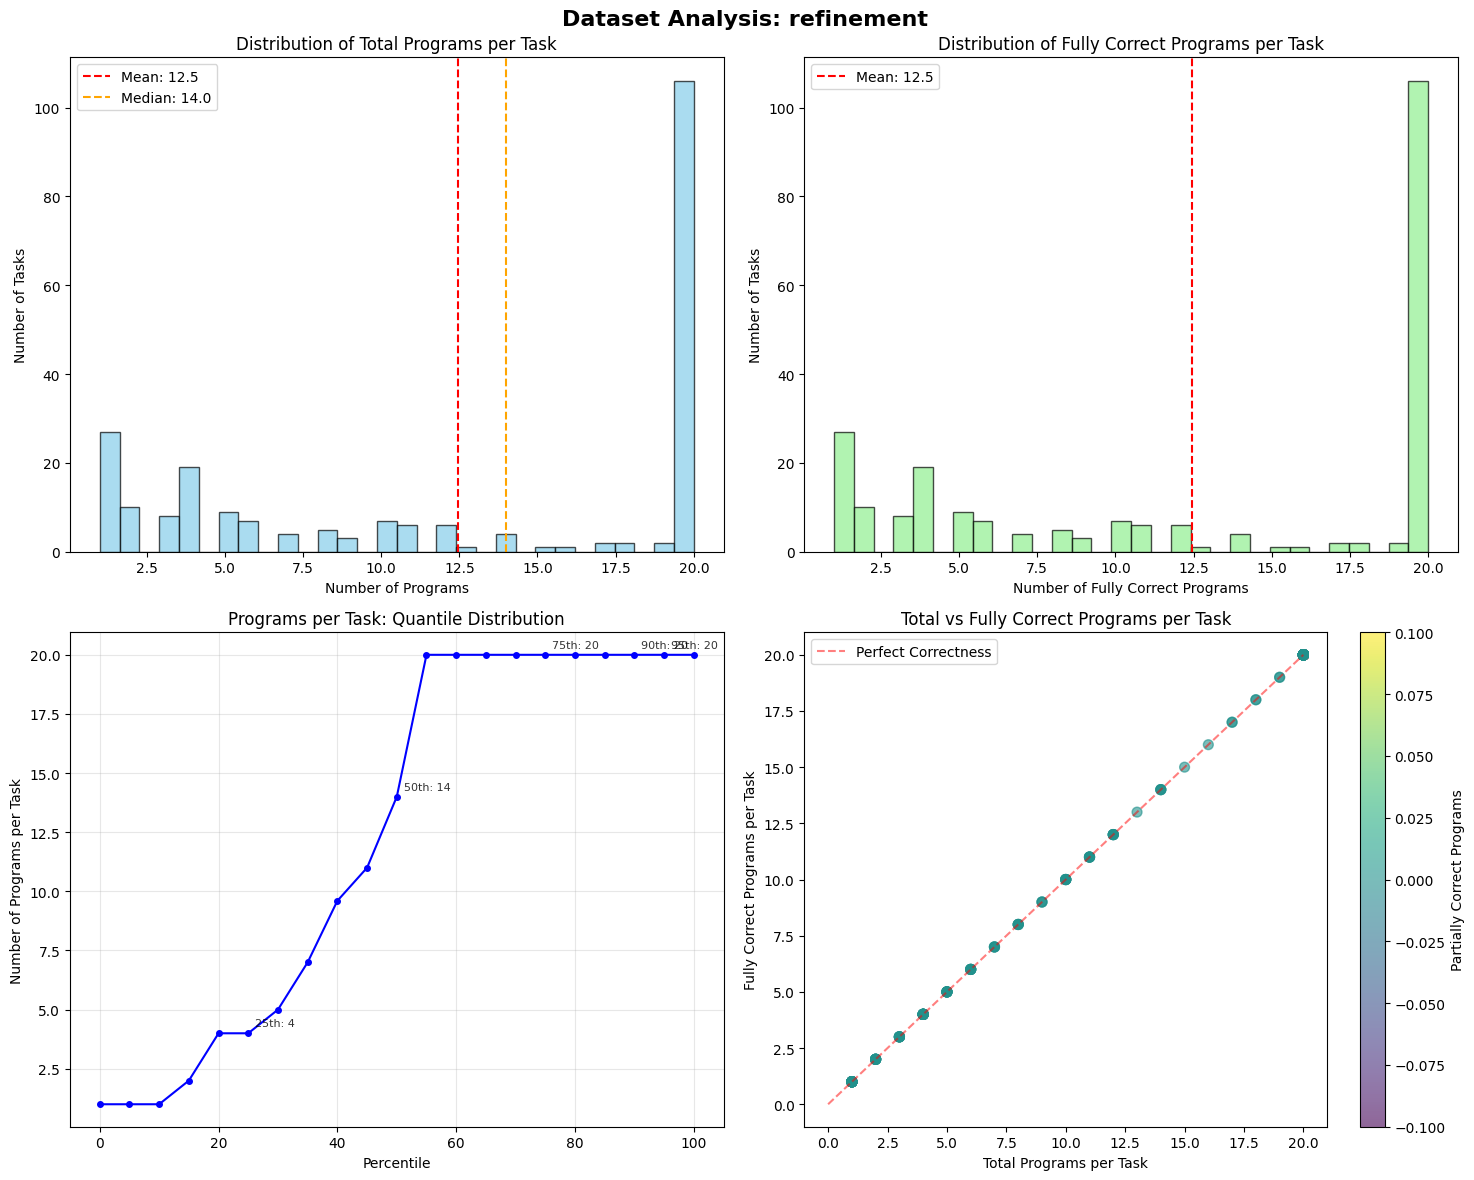


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [26]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, "refinement")

In [27]:
sample = df[["code_original", "code"]].sample(n=10, random_state=42)
for idx, row in sample.iterrows():
    print(f"Row {idx}:")
    print("Original code:\n", row["code_original"])
    print("Refined code:\n", row["code"])
    print("-" * 80)

Row 5937:
Original code:
 def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    rows = len(grid_lst)
    cols = len(grid_lst[0])
    new_grid = [[0] * cols for _ in range(rows)]
    for i in range(rows):
        for j in range(cols):
            if grid_lst[i][j] == 3:
                new_grid[i][j] = 3
    for i in range(rows):
        for j in range(cols):
            if grid_lst[i][j] == 2:
                if j < cols // 2:
                    if j + 2 < cols:
                        new_grid[i][j + 2] = 2
                elif i + 2 < rows:
                    new_grid[i + 2][j] = 2
                elif i - 2 >= 0:
                    new_grid[i - 2][j] = 2
    return new_grid
Refined code:
 def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    rows = len(grid_lst)
    cols = len(grid_lst[0])
    new_grid = [[0] * cols for _ in range(rows)]
    for i in range(rows):
        for j in range(cols):
            if grid_lst[i][j] == 3:
                new_grid[i][j]